## Load data

In [1]:
from argon.datasets.envs.pusht import load_pytorch_pusht_data
import jax
import jax.numpy as jnp
import jax.tree_util as tree

# Path to your .zarr.zip data
pusht_data_path = "/home/qul12/claireji/mode-collapse/argon/pusht_data.zarr"

# Load using pytorch-compatible function that doesn’t require `graphdef`
print("Loading PushT data...")
dataset = load_pytorch_pusht_data(pusht_data_path)
print(f"Loaded {len(dataset.sequences)} trajectories consisting of {len(dataset.elements)} elements.")


Loading PushT data...
Loaded 1250 trajectories consisting of 457680 elements.


## Explore Data

In [2]:
dataset

SequenceData(elements=<argon.data.PyTreeData object at 0x7f150cac2900>, sequences=<argon.data.PyTreeData object at 0x7f150c11f250>)

In [3]:
# Elements are the individual positions, all sequences concatenated
sample = dataset.elements[0]
sample

Step(state=None, reduced_state=SystemState(time=Array(1., dtype=float32), qpos=Array([-1.0138963,  1.0148815, -1.0158731,  1.0158731, -0.       ],      dtype=float32), qvel=Array([0., 0., 0., 0., 0.], dtype=float32), act=Array([], shape=(0,), dtype=float32)), observation=None, action=PushTAgentPos(agent_pos=Array([-1.0139049,  1.0148848], dtype=float32)))

In [ ]:
# Sequences tell us where each sequence begins and ends in the list of all positions
for idx in range(10):
    sample_info = dataset.sequences[idx]
    print(sample_info)

SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, start_idx=Array(0, dtype=int32), end_idx=Array(264, dtype=int32), length=Array(264, dtype=int32))
SequenceInfo(info=None, 

In [6]:
import argon
import numpy as np
sum(argon.tree.leaves(dataset.sequences)[1])
np.mean(argon.tree.leaves(dataset.sequences)[1])
len(argon.tree.leaves(dataset.sequences)[1])

1250

In [7]:
argon.tree.leaves(dataset.sequences)

[Array([   264,    488,    812, ..., 456892, 457276, 457680], dtype=int32),
 Array([264, 224, 324, ..., 344, 384, 404], dtype=int32),
 Array([     0,    264,    488, ..., 456548, 456892, 457276], dtype=int32)]

In [8]:
# Optional: peek at some fields
print("\nSample reduced_state:", sample.reduced_state)
print("\nSample reduced_state shape:", jax.tree.map(lambda x: x.shape, sample.reduced_state))
print("Sample agent_pos:", sample.action.agent_pos)


Sample reduced_state: SystemState(time=Array(1., dtype=float32), qpos=Array([-1.0138963,  1.0148815, -1.0158731,  1.0158731, -0.       ],      dtype=float32), qvel=Array([0., 0., 0., 0., 0.], dtype=float32), act=Array([], shape=(0,), dtype=float32))

Sample reduced_state shape: SystemState(time=(), qpos=(5,), qvel=(5,), act=(0,))
Sample agent_pos: [-1.0139049  1.0148848]


In [9]:
# PyTree allows us to grab an entire list of the same attribute across entries (positions or sequences)
dataset.elements.as_pytree()

Step(state=None, reduced_state=SystemState(time=Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), qpos=Array([[-1.0138963,  1.0148815, -1.0158731,  1.0158731, -0.       ],
       [-1.0139049,  1.0148848, -1.0158731,  1.0158731, -0.       ],
       [-1.0139118,  1.0148913, -1.0158731,  1.0158731, -0.       ],
       ...,
       [-1.013889 ,  1.014881 , -1.0158731,  1.0158731, -0.       ],
       [-1.013889 ,  1.014881 , -1.0158731,  1.0158731, -0.       ],
       [-1.013889 ,  1.014881 , -1.0158731,  1.0158731, -0.       ]],      dtype=float32), qvel=Array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), act=Array([], shape=(457680, 0), dtype=float32)), observation=None, action=PushTAgentPos(agent_pos=Array([[-1.0139049,  1.0148848],
       [-1.0139118,  1.0148913],
       [-1.0139173,  1.0149009],
       ...,
       [-1.013889 ,  1.01488

## Prepare Data

In [10]:
# Convert all trajectories to a flat array for clustering

print("\nPreparing data for clustering...")
agent_positions = dataset.elements.as_pytree().action.agent_pos

print("All agent_pos shape:", agent_positions.shape)


Preparing data for clustering...
All agent_pos shape: (457680, 2)


In [11]:
sequence_info = dataset.sequences.as_pytree()
start_indices = sequence_info.start_idx  # shape: (N_sequences,)
end_indices = sequence_info.end_idx      # shape: (N_sequences,)
print(start_indices)
print(end_indices)

[     0    264    488 ... 456548 456892 457276]
[   264    488    812 ... 456892 457276 457680]


## Analyze Data

### By position

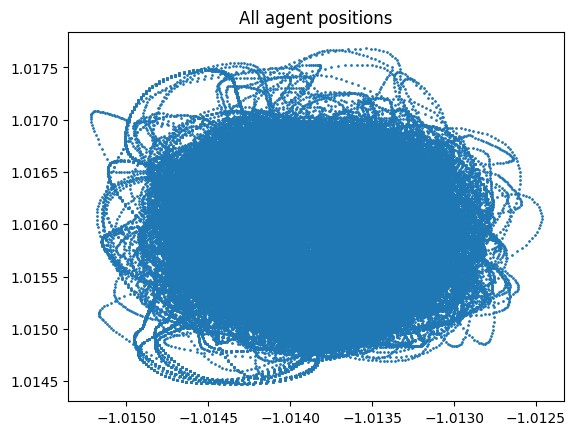

In [12]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(agent_positions[:, 0], agent_positions[:, 1], s=1)
plt.title("All agent positions")
plt.show()

In [13]:
X_pos = np.array(agent_positions)  # shape: (457680, 2)

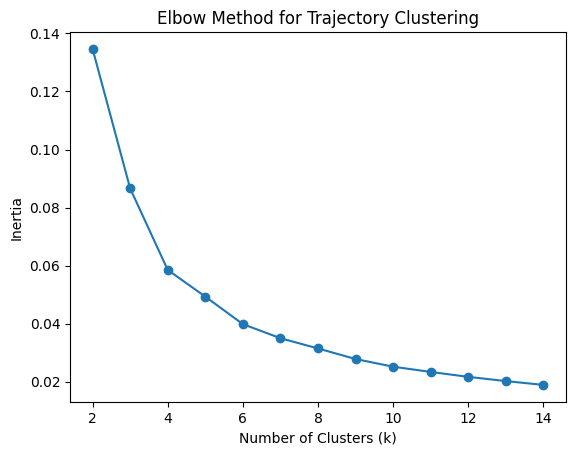

In [14]:
from sklearn.cluster import KMeans

inertias = []
ks = range(2, 15)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pos)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Trajectory Clustering")
plt.show()

In [15]:
# Now you can do clustering with sklearn, e.g.:
best_num_clusters = 6
kmeans_pos = KMeans(n_clusters=best_num_clusters, random_state=0).fit(X_pos)
labels_pos = kmeans_pos.labels_
centroids_pos = kmeans_pos.cluster_centers_

print("Cluster centers (positions):", centroids_pos)

Cluster centers (positions): [[-1.0138967  1.0165788]
 [-1.0142637  1.0154921]
 [-1.0134571  1.0155632]
 [-1.0133369  1.0161444]
 [-1.0144261  1.0161073]
 [-1.0138767  1.0149647]]


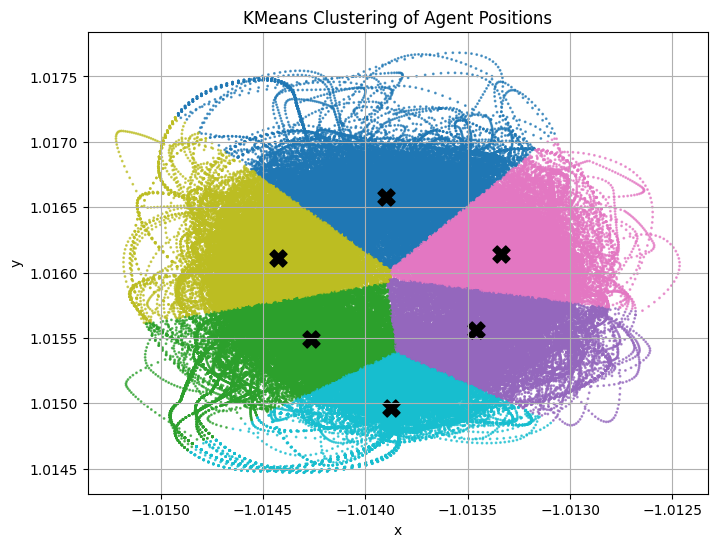

In [16]:
# Individual positions
plt.figure(figsize=(8,6))
plt.scatter(X_pos[:, 0], X_pos[:, 1], c=labels_pos, cmap='tab10', s=1, alpha=0.7)
plt.scatter(centroids_pos[:, 0], centroids_pos[:, 1], c='black', s=150, marker='X', label='Centroids')
plt.title("KMeans Clustering of Agent Positions")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [17]:
import numpy as np
np.std(kmeans.labels_), np.mean(kmeans.labels_)

(np.float64(4.012938453550442), np.float64(5.728325467575599))

### By sequence

In [36]:
from scipy.interpolate import interp1d

def resample_traj(traj: np.ndarray, n_points: int = 20):
    """Resample a trajectory (T x 2) to n_points x 2"""
    T = traj.shape[0]
    x = np.linspace(0, 1, T)
    f = interp1d(x, traj, axis=0, kind='linear')
    return f(np.linspace(0, 1, n_points))

n_sampling_points = 200
trajectories = []
for start, end in zip(start_indices, end_indices):
    traj = np.array(agent_positions[start:end])  # shape: (T, 2)
    if len(traj) < 2: continue  # skip empty
    traj_resampled = resample_traj(traj, n_points=n_sampling_points)  # shape: (n_sampling_points, 2)
    trajectories.append(traj_resampled.flatten())  # shape: (n_sampling_points*2,)
X_seq = np.stack(trajectories)  # shape: (N_sequences, n_sampling_points*2)
print(X_seq.shape)

(1250, 400)


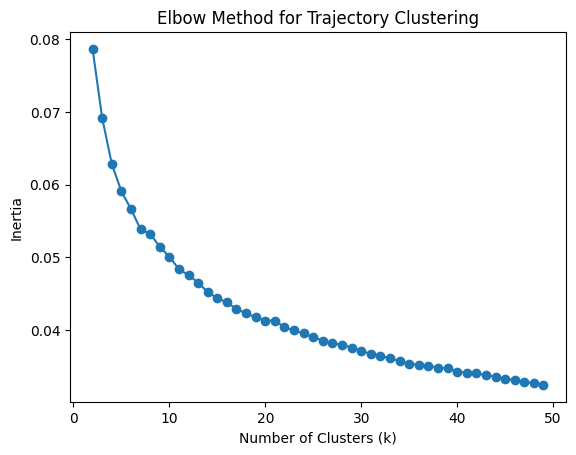

In [35]:
inertias = []
ks = range(2, 50)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_seq)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Trajectory Clustering")
plt.show()

In [39]:
best_num_clusters = 20
kmeans_seq = KMeans(n_clusters=best_num_clusters, random_state=0).fit(X_seq)
labels_seq = kmeans_seq.labels_
centroids_seq = kmeans_seq.cluster_centers_

print("Cluster centers (trajectories):", centroids_seq)

Cluster centers (trajectories): [[-1.01395139  1.01497522 -1.01402108 ...  1.01488101 -1.0139005
   1.01490274]
 [-1.01388022  1.01488833 -1.01387423 ...  1.01488105 -1.01388758
   1.01489264]
 [-1.0138897   1.01490381 -1.01389206 ...  1.01488091 -1.01389162
   1.01489121]
 ...
 [-1.01388897  1.01490225 -1.01388515 ...  1.01488104 -1.01389282
   1.01489892]
 [-1.0139068   1.01486437 -1.01392083 ...  1.01488094 -1.01389534
   1.01487846]
 [-1.01392414  1.01489373 -1.01395687 ...  1.01488113 -1.01389459
   1.01488667]]


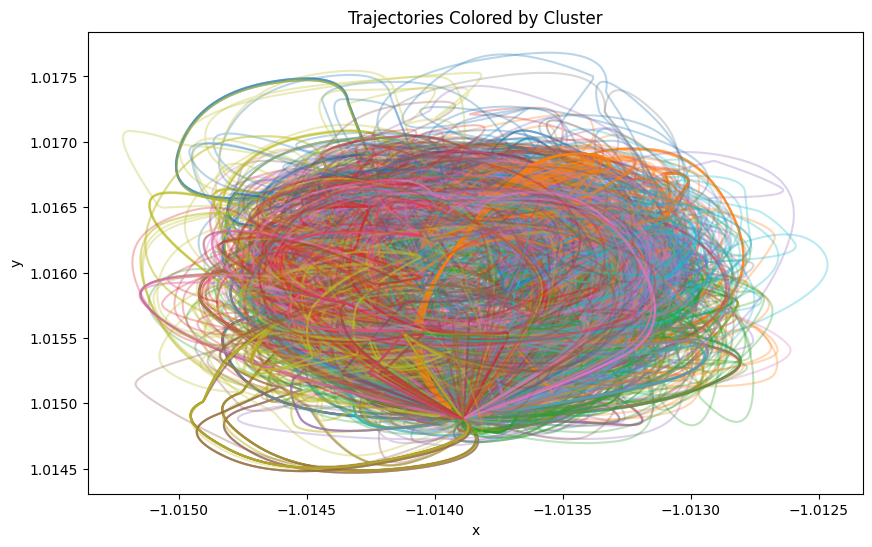

In [40]:
plt.figure(figsize=(10,6))
for i, (start, end) in enumerate(zip(start_indices, end_indices)):
    traj = np.array(agent_positions[start:end])
    if i < len(labels_seq):
        plt.plot(traj[:, 0], traj[:, 1], alpha=0.3, label=f"Cluster {labels_seq[i]}" if i < 8 else "", color=f"C{labels_seq[i] % 10}")
plt.title("Trajectories Colored by Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

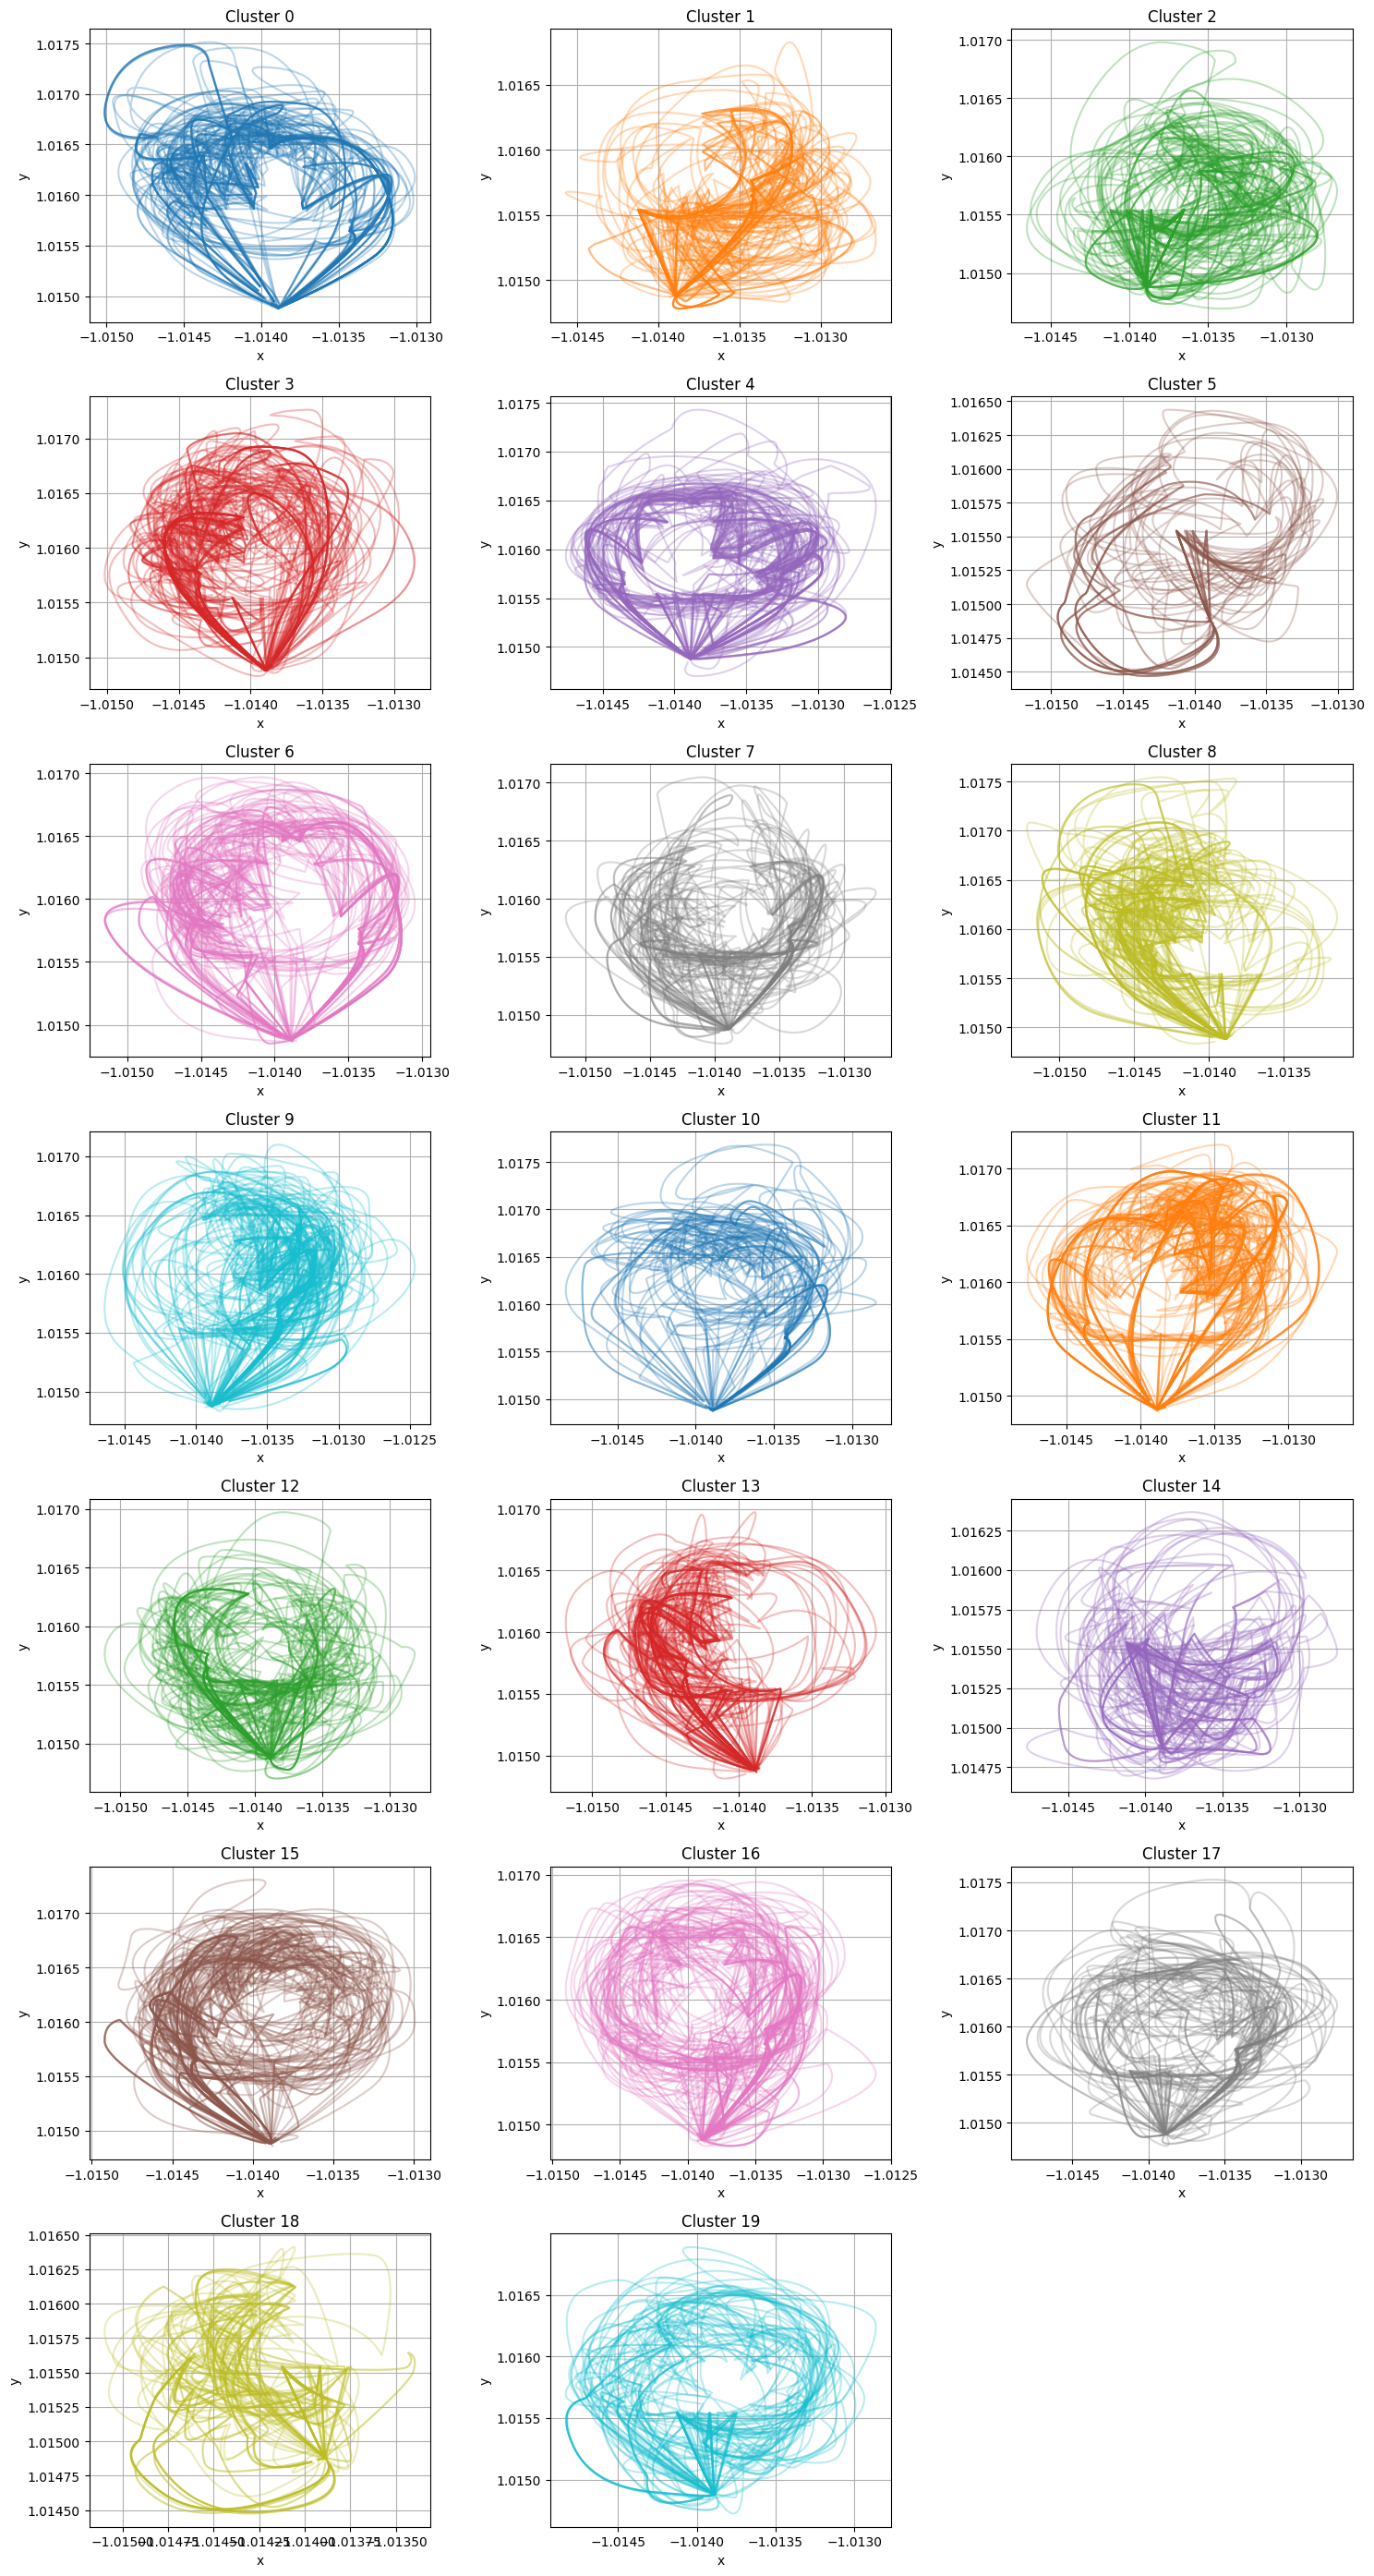

In [41]:
n_clusters = max(labels_seq) + 1
ncols = 3
nrows = (n_clusters + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
axes = axes.flatten()

for cluster_id in range(n_clusters):
    ax = axes[cluster_id]
    for i, (start, end) in enumerate(zip(start_indices, end_indices)):
        if labels_seq[i] == cluster_id:
            traj = np.array(agent_positions[start:end])
            ax.plot(traj[:, 0], traj[:, 1], alpha=0.3, color=f"C{cluster_id % 10}")
    ax.set_title(f"Cluster {cluster_id}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)

# Hide unused subplots
for j in range(n_clusters, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



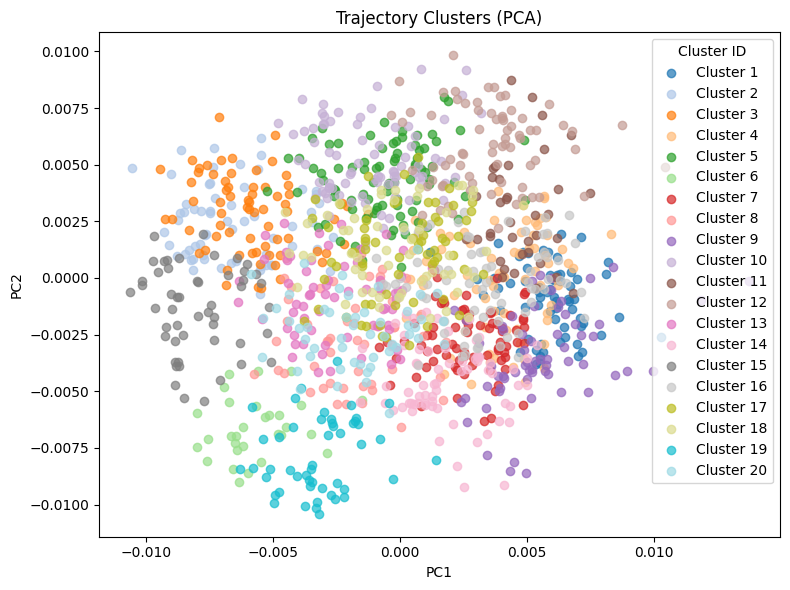

In [42]:
from sklearn.decomposition import PCA

# Dimensionality reduction
pca = PCA(n_components=2)
X_seq_2d = pca.fit_transform(X_seq)  # shape: (N_sequences, 2)

# Get number of unique labels
num_clusters = np.max(labels_seq) + 1
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(num_clusters)]

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    mask = labels_seq == i
    plt.scatter(X_seq_2d[mask, 0], X_seq_2d[mask, 1], 
                color=colors[i], label=f'Cluster {i+1}', alpha=0.7)

plt.title("Trajectory Clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster ID", loc='best')
plt.tight_layout()
plt.show()


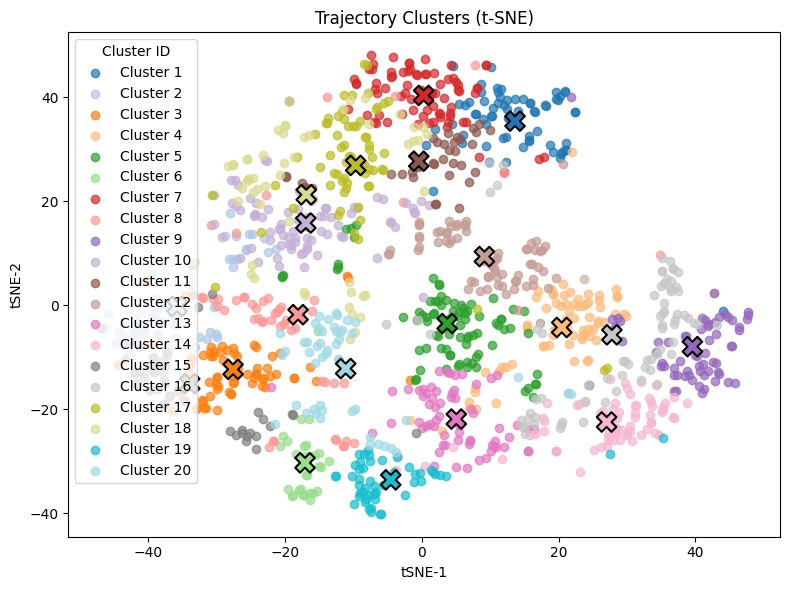

In [43]:
from sklearn.manifold import TSNE

# Run t-SNE on the sequences
X_seq_2d = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_seq)

# Compute centroid locations in 2D space from clustered points
centroids_2d = np.array([
    X_seq_2d[labels_seq == i].mean(axis=0)
    for i in range(num_clusters)
])

# Determine number of clusters
num_clusters = np.max(labels_seq) + 1
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(num_clusters)]

# Plot
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    mask = labels_seq == i
    plt.scatter(X_seq_2d[mask, 0], X_seq_2d[mask, 1],
                color=colors[i], label=f"Cluster {i+1}", alpha=0.7)
plt.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    color=colors, marker='X', s=200, edgecolor='black', linewidth=1.5, zorder=3
)

plt.title("Trajectory Clusters (t-SNE)")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend(title="Cluster ID", loc="best")
plt.tight_layout()
plt.show()

In [33]:
# import umap

# X_seq_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=0).fit_transform(X_seq)

# plt.figure(figsize=(8,6))
# plt.scatter(X_seq_2d[:, 0], X_seq_2d[:, 1], c=labels_seq, cmap='tab20')
# plt.title("Trajectory Clusters (UMAP)")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.show()

ModuleNotFoundError: No module named 'umap'

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_seq_scaled = scaler.fit_transform(X_seq)  # feed this into GMM instead of X_seq


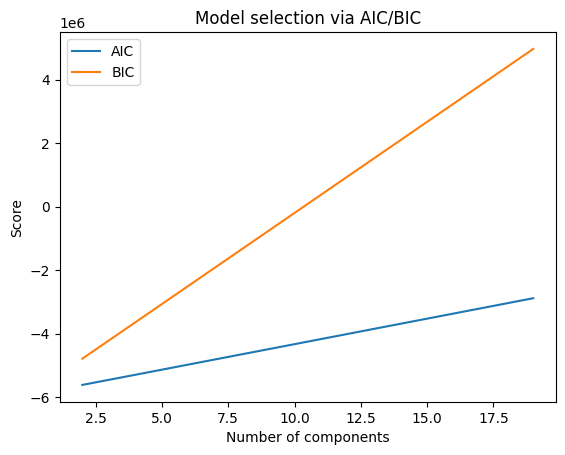

In [47]:
from sklearn.mixture import GaussianMixture

aic = []
bic = []
ks = range(2, 20)
for k in ks:
    gmm_k = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_seq)
    aic.append(gmm_k.aic(X_seq))
    bic.append(gmm_k.bic(X_seq))

plt.plot(ks, aic, label='AIC')
plt.plot(ks, bic, label='BIC')
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.title("Model selection via AIC/BIC")
plt.legend()
plt.show()


In [48]:
n_components = 20  # change this based on silhouette or BIC
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(X_seq)

gmm_labels_seq = gmm.predict(X_seq)             # Hard labels
gmm_probs_seq = gmm.predict_proba(X_seq)        # Soft cluster assignments


In [55]:
print("Unique cluster labels:", np.unique(gmm_labels_seq))

from collections import Counter

counts = Counter(gmm_labels_seq)
print("Cluster sizes:", counts)


Unique cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Cluster sizes: Counter({np.int64(13): 109, np.int64(6): 109, np.int64(17): 99, np.int64(1): 87, np.int64(12): 85, np.int64(5): 81, np.int64(18): 78, np.int64(3): 72, np.int64(2): 70, np.int64(14): 67, np.int64(4): 56, np.int64(11): 56, np.int64(15): 49, np.int64(7): 40, np.int64(0): 39, np.int64(9): 35, np.int64(10): 33, np.int64(8): 32, np.int64(16): 30, np.int64(19): 23})


In [50]:
gmm_probs_seq

array([[1.92784763e-22, 8.62234141e-05, 9.99610979e-01, ...,
        2.95222200e-07, 1.65070560e-06, 5.56876421e-06],
       [2.14316908e-22, 1.34378571e-04, 9.91863004e-01, ...,
        6.35601141e-05, 1.31317111e-09, 1.25363303e-06],
       [6.80496294e-23, 2.77239642e-04, 9.96641870e-01, ...,
        7.91779905e-05, 3.06238345e-11, 4.82936590e-11],
       ...,
       [3.66821233e-08, 3.26717073e-06, 1.31685394e-14, ...,
        1.37229705e-03, 1.12540556e-11, 1.09726086e-12],
       [9.49713747e-24, 2.55640951e-06, 3.03566205e-12, ...,
        8.69843063e-05, 9.32924263e-05, 7.17479837e-09],
       [9.24505451e-11, 1.72539417e-15, 2.80256597e-12, ...,
        1.10172296e-10, 2.80788681e-03, 1.66072386e-04]], shape=(1250, 20))

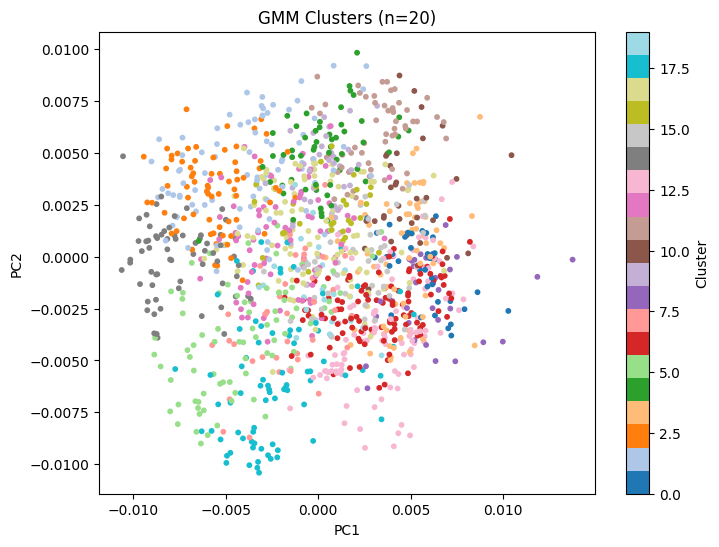

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_2d = PCA(n_components=2).fit_transform(X_seq)  # or use t-SNE/UMAP

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=gmm_labels_seq, cmap='tab20', s=10)
plt.title(f"GMM Clusters (n={n_components})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()


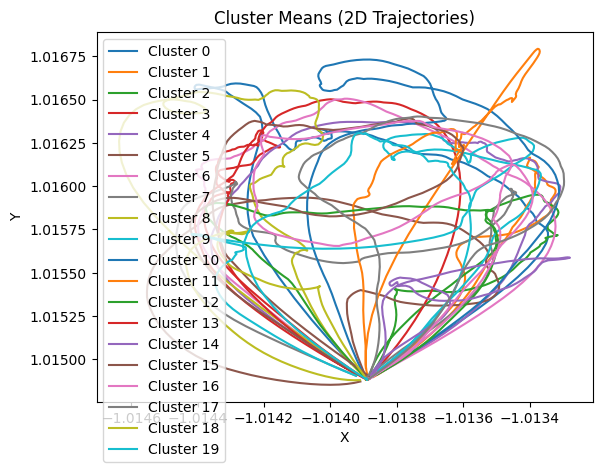

In [52]:
means = gmm.means_.reshape(n_components, n_sampling_points, 2)

for i in range(n_components):
    plt.plot(means[i, :, 0], means[i, :, 1], label=f'Cluster {i}')
plt.title("Cluster Means (2D Trajectories)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()